In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import contour_conversion.image_conversion as cp
import time

from numba import jit

import shapely.affinity as sa

import fill_strategy.zigzag as ZZ

import os

In [37]:
filename = "../images/wolf.png"

image = cv2.imread(filename, 0)
not image is None

True

In [38]:
from shapely.geometry import Polygon, LineString, Point, MultiLineString

In [39]:
def plot_path(path):
    
    X = []
    Y = []
    for p in list(path):
        X.append(p[0])
        Y.append(p[1])

    plt.plot(X,Y)

In [40]:
%reload_ext autoreload
%autoreload 2

p_list = cp.execute(image)

In [41]:
%%time

path = ZZ.execute(p_list, 5)


for i in range(len(path)):

    for j in range(len(path[i])):

        path[i][j] = [(p[0],p[1]) for p in path[i][j]]

INFO:Polygon: 0: 0.009555578231811523
INFO:TOTAL TIME: 0.010136604309082031


CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 10.8 ms


In [42]:
from metrics import Metrics

m = Metrics(underfill=True, overfill=True)

In [44]:
path

[[[(88.0, 15.0),
   (103.0, 15.0),
   (107.0, 20.0),
   (83.0, 20.0),
   (78.0, 25.0),
   (110.0, 25.0),
   (112.0, 30.0),
   (76.0, 30.0),
   (73.0, 35.0),
   (114.0, 35.0),
   (117.0, 40.0),
   (70.0, 40.0),
   (66.0, 45.0),
   (121.0, 45.0),
   (123.0, 50.0),
   (64.0, 50.0),
   (62.0, 55.0),
   (127.0, 55.0),
   (130.0, 60.0),
   (61.0, 60.0),
   (58.0, 65.0),
   (133.0, 65.0),
   (137.0, 70.0),
   (58.0, 70.0),
   (58.0, 75.0),
   (142.0, 75.0),
   (149.0, 80.0),
   (58.0, 80.0),
   (58.0, 85.0),
   (161.0, 85.0),
   (173.0, 90.0),
   (56.0, 90.0),
   (23.0, 95.0),
   (181.0, 95.0),
   (186.0, 100.0),
   (18.0, 100.0),
   (16.0, 105.0),
   (191.0, 105.0),
   (193.0, 110.0),
   (16.0, 110.0),
   (18.0, 115.0),
   (195.0, 115.0),
   (197.0, 120.0),
   (20.0, 120.0),
   (24.0, 125.0),
   (200.0, 125.0),
   (202.0, 130.0),
   (27.0, 130.0),
   (31.0, 135.0),
   (205.0, 135.0),
   (207.0, 140.0),
   (35.0, 140.0),
   (39.0, 145.0),
   (209.0, 145.0),
   (212.0, 150.0),
   (42.0, 150.0)

In [45]:
m.measure(path[0], os.path.basename(filename), "ZZ", 5, p_list)


{'Filename': 'wolf.png',
 'Method': 'ZZ',
 'Distance': 5,
 'Segments': 6,
 'Commands': 790,
 'Curvature': nan,
 'Underfill': 0.0021077723782075212,
 'Overfill': 0.001316937742667257}

In [30]:

'''
Get the neighbor indices
'''
def neighbors(i1, length):
    
    i0 = i1-1 if i1 != 0 else length-1
    i2 = i1+1 if i1+1 != length else 0

    return i0,i1,i2


'''
Calculate metrics of path
'''
def metrics(path):      
    
    sharpness = 0

    for i1 in range(len(path)):
        
        i0,i1,i2 = neighbors(i1, len(path))
        
        p0 = path[i0]
        p1 = path[i1]
        p2 = path[i2]
                
        a0 = np.arctan2(p1[1]-p0[1], p1[0]-p0[0])
        a2 = np.arctan2(p2[1]-p1[1], p2[0]-p1[0])

        # get the angle change
        da = a2-a0
        
        sharpness += abs(da)
        
    return sharpness
    
    

In [31]:
m = []

for p in path[0]:
    
    m.append(metrics(p)/len(p))
    
np.average(m)

2.121268061899698

<IPython.core.display.Javascript object>


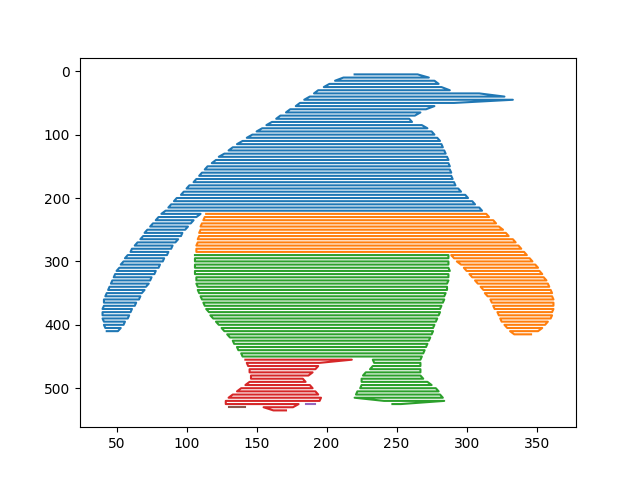

In [8]:
%matplotlib notebook

for obj in path:
    for p in obj:
        plot_path(p)
    
plt.gca().invert_yaxis()

In [11]:
from gcode import GcodeWriter

In [14]:
result = GcodeWriter(filename='penguin.gcode', scale = 0.1)

In [16]:
_ = result.convert(path[0])

In [18]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))